### Modeling the spread of rabies in one dimension

In this notebook, we will move from the 2 connected patches described in [Notebook 8](https://github.com/laser-base/laser-generic/blob/50796ab5a253df168255e8a3ac54b766f6aa55d5/notebooks/08_2patch_SIR_wbirths_correlation.ipynb) to a 1-D grid of connected population patches.  This is the scenario explored to describe the spatial spread of rabies in foxes in the work of [Kallen, Arcuri, and Murray, Journal of Theoretical Biology (1985) 116, 377-393](https://pubmed.ncbi.nlm.nih.gov/4058027/). The relevant model equations (note that these are now PDEs rather than the ODEs of previous notebooks) are:
$$
\frac{\partial S}{\partial t} = -KIS \\

\frac{\partial I}{\partial t} = D \frac{\partial^2 I}{\partial x^2} + KIS - \mu I
$$ 

and come to the conclusion that this system supports traveling waves with velocity bounded below by 

$$
c = 2 \sqrt{D \mu (1/r -1)}
$$

where $r = \frac{\mu}{K S_0}$ and $S_0$ is the initial density of susceptibles.

The analogy to the SIR model equations we have been using is clear, though this model conceptually different in specific ways from that model as we now have spatially dimensional quantities.  For example, I & S are infective/susceptible population densities rather than population counts, which affects translating between the $K$ of this model and the $\beta$ of the SIR; the derived quantity $r$ is clearly analogous to $\frac{1}{R_0}$ of the SIR model, but requires the presence of the initial susceptible density to be properly dimensionless, and rabies being invariably fatal, $\mu$ represents the mortality of rabies rather than the $\gamma$ we would use for recovery.  

With all that said, if we are careful about translation between parameters, and appropriately construct the transmission network to appropriately reflect 1-D diffusion, we ought to be able to reproduce this model in our SIR implementation, and recapitulate the traveling wave behavior of the outbreak.  As we do this, we will also run into two well-understood issues in simulating traveling waves of the expected wavespeed on a finite lattice, both biasing us to produce slower waves on average.  

The first comes from discretization - we are transitioning from a PDE continuous in space, time, and the relevant variable $I$, to a simulation that is discrete in all 3.  This discretization will make it impossible for infection to travel more than 1 lattice spacing per simulation timestep, so in parameter regimes where the expected wavespeed approaches a lattice spacing per simulation timestep, our model will be incapable of demonstrating that.  

The second slowdown ill come from discretization of the population itself, and from stochasticity.  This phenomenon is sometimes referred to as the "attofox" problem, and is discussed, e.g., in the chapter on Spatial Modeling in Keeling and Rohani, Modeling Infectious Diseases in Humans and Animals.  In a model with deterministic dynamics and continuous populations, any fraction of infectivity deposited in a population can generate fractional infectives, and deterministically kick off the start of a local outbreak.  In a discrete population, stochastic model, we cannot have fewer than a single infected individual, so when only small amounts of infectivity move (D is small), it can take a long time to infect an individual in an uninfected location, and the wavespeed will on average be slower.  

In fact, as long as $D>0$ and $1/r >1$, the continuous equation is guaranteed to support traveling waves, but for small D and small 1/r the stochastic version may simply die out in the initial node before successfully propagating to adjacent nodes, or it may die out at some subsequent node along the way.

So as we fit models, we should expect to see slower-than-expected waves both when the expected wavespeed is very slow, and when it is very fast, and a goldilocks regime in the middle where we can simulate something closer to the expected wavespeed.

In [1]:
import numpy as np
import pandas as pd
from laser.core.propertyset import PropertySet
import laser.core.distributions as dists
from laser.generic import SIR
from laser.generic import Model
from laser.core.utils import grid
import laser.core
import laser.generic
import matplotlib.pyplot as plt
import os
from scipy.optimize import fsolve


print(f"{np.__version__=}")
print(f"{laser.core.__version__=}")
print(f"{laser.generic.__version__=}")


np.__version__='2.2.6'
laser.core.__version__='0.8.0'
laser.generic.__version__='0.0.0'


In [2]:
#Set up the network and initial conditions
npatches = 201
pop = 1000
scenario = grid(M=1, N=npatches, node_size_degs=0.05, population_fn=lambda x,y: pop, origin_x=0, origin_y=0)
initial_infected = 3
scenario["I"] = 0
scenario["R"] = 0
scenario["S"] = scenario.population
scenario.loc[scenario.nodeid==101,"I"] = initial_infected
scenario.loc[scenario.nodeid==101,"S"] = scenario.loc[scenario.nodeid==101,"population"]-initial_infected

# The transmission network
Spatial transmission in this rabies model is contained in the diffusive term $D \frac{\partial^2 I}{\partial x^2}$.  We are operating on a discretized 1-D grid, and will take advantage of the usual way to discretize a second derivative

$$
D \frac{\partial^2 I}{\partial x^2} \rightarrow D \frac {I_{x-h} - 2 I_{x} + I_{x+h}} {h^2}
$$

To translate this into a network structure for the model, we can arbitrarily set the  length scale $h$ to be 1 in units of the grid spacing.  Looking at the above, from the perspective of an arbitrary node $i$, the transmission matrix must "send" $D I_i$ units of infectivity to the adjacent nodes on either side, and remove that infectivity from the local pool.   Looking at the spatial transmission code (line 1006-8 in src/laser_generic/models/components.py), we see that spatial transmission is handled by multiplying the transmission matrix and the vector of infectivities by node, and that it internally handles subtracting the "outbound infectivity" from the local source.  Thus, the above discretization can be accomplished by filling the value $D$ on the first superdiagonal and subdiagonal of the transmission matrix, and 0 everywhere else.

In [3]:
infmean = 25.0
R0 = 2.0
nticks = 10 * 365
D = .01
parameters = PropertySet(
    {
        "seed": np.random.randint(0, 1000000),
        "nticks": nticks,
        "verbose": True,
        "beta": R0 / infmean,
        "inf_mean": infmean,
    }
)

infdurdist = dists.exponential(scale=parameters.inf_mean)
model = Model(scenario, parameters)
model.network = 0*model.network
np.fill_diagonal(model.network[1:], D)
np.fill_diagonal(model.network[:,1:], D)

model.components = [
    SIR.Susceptible(model),
    SIR.Recovered(model),
    SIR.Infectious(model, infdurdist),
    SIR.Transmission(model, infdurdist),
]
model.run()



201,000 agents in 201 node(s): 100%|██████████| 3650/3650 [00:01<00:00, 2114.57it/s]


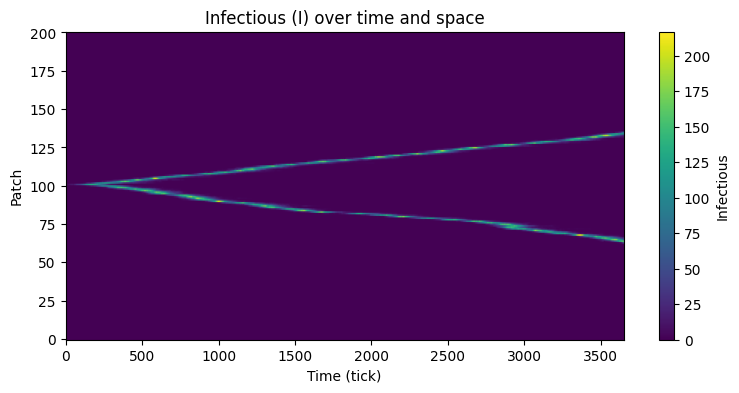

In [4]:
plt.figure(figsize=(9, 4))
plt.imshow(model.nodes.I.T, aspect='auto', origin='lower')
plt.xlabel('Time (tick)')
plt.ylabel('Patch')
plt.title('Infectious (I) over time and space')
plt.colorbar(label='Infectious')
plt.show()


In [5]:
from scipy.stats import linregress

# Find the time (tick) of peak I for each node
peak_times = model.nodes.I.argmax(axis=0)  # shape: (npatches,)

# Get the node indices for right-going (101 to 200) and left-going (100 to 0) waves
right_nodes = np.arange(101, npatches)
left_nodes = np.arange(100, -1, -1)

# Fit a line to peak_times vs node index for each direction to estimate velocity (slope = 1/velocity)

# Right-going wave
right_peak_times = peak_times[right_nodes]
slope_r, intercept_r, r_value_r, p_value_r, std_err_r = linregress(right_nodes[right_peak_times>0], right_peak_times[right_peak_times > 0])
velocity_right = 1 / slope_r if slope_r != 0 else np.nan

# Left-going wave
left_peak_times = peak_times[left_nodes]
slope_l, intercept_l, r_value_l, p_value_l, std_err_l = linregress(left_nodes[left_peak_times>0], left_peak_times[left_peak_times > 0])
velocity_left = -1 / slope_l if slope_l != 0 else np.nan  # negative because left

print(f"Estimated right-going wavespeed: {velocity_right:.3f} patches/tick")
print(f"Estimated left-going wavespeed: {velocity_left:.3f} patches/tick")
print(f"Expected wavespeed: {2*np.sqrt(D/infmean*(R0-1)):.3f} patches/tick")

Estimated right-going wavespeed: 0.009 patches/tick
Estimated left-going wavespeed: 0.010 patches/tick
Expected wavespeed: 0.040 patches/tick


In [6]:
# from matplotlib.animation import FuncAnimation
# from IPython.display import HTML

# fig, ax = plt.subplots()
# line, = ax.plot([], [], lw=2)
# ax.set_xlim(0, npatches-1)
# ax.set_ylim(0, model.nodes.I.max())
# ax.set_xlabel('Patch x')
# ax.set_ylabel('Infectious (I)')
# ax.set_title('Infectious population over time')

# def init():
#     line.set_data([], [])
#     return line,

# def update(frame):
#     line.set_data(np.arange(npatches), model.nodes.I[frame, :])
#     ax.set_title(f'Infectious population at t={frame}')
#     return line,

# ani = FuncAnimation(fig, update, frames=nticks, init_func=init, blit=True, interval=30)
# HTML(ani.to_jshtml())